In [1]:
# Refactor simulation parameters into a single config dictionary for easier parameter sweeps

# Define centralized simulation parameters
sim_params = {
    "base_privacy_sensitivity": 0.5,
    "anonymized_bonus": 0.3,
    "deanonymized_penalty": -0.3,
    "purpose_penalty_per_item": 0.05,
    "advertiser_sensitivity_bonus": 0.2,
    "base_privacy_cost_anonymized": 0.3,
    "base_privacy_cost_deanonymized": 0.6,
    "advertiser_cost_bonus": 0.2,
    "invasive_purpose_cost_bonus": 0.1,
    "anonymization_penalty_multiplier": 0.8,
    "union_effect_multiplier": 0.1,
    "commission_rate": 0.4,
    "num_users": 100,
    "num_rounds": 10,
}

# Now rewrite the key functions to use sim_params instead of hardcoded numbers

def calculate_privacy_sensitivity(statements, mode="papaya", params=sim_params):
    privacy_scores = {}
    for statement in statements:
        anonymization = statement["A"]
        platform = statement["P"]
        purposes = statement["R"]

        sensitivity_score = params["base_privacy_sensitivity"]
        if anonymization == "Anonymized":
            sensitivity_score += params["anonymized_bonus"]
        else:
            sensitivity_score += params["deanonymized_penalty"]

        sensitivity_score -= params["purpose_penalty_per_item"] * len(purposes)
        if platform == "Advertisers":
            sensitivity_score += params["advertiser_sensitivity_bonus"]

        sensitivity_score = max(0, min(1, sensitivity_score))
        for purpose in purposes:
            privacy_scores[(platform, purpose, anonymization)] = sensitivity_score

    return privacy_scores

def calculate_privacy_cost(platform, purpose, anonymization, params=sim_params):
    base_cost = params["base_privacy_cost_anonymized"] if anonymization == "Anonymized" else params["base_privacy_cost_deanonymized"]
    if platform == "Advertisers":
        base_cost += params["advertiser_cost_bonus"]
    if purpose in ["Targeted Ads", "Email Marketing"]:
        base_cost += params["invasive_purpose_cost_bonus"]
    return min(1, base_cost)

# Output the refactored configuration and parameter-dependent functions
refactored_components = {
    "sim_params": sim_params,
    "calculate_privacy_sensitivity": calculate_privacy_sensitivity,
    "calculate_privacy_cost": calculate_privacy_cost
}

# Refactor User, Platform, and Broker classes to use centralized simulation parameters

class User:
    def __init__(self, user_id, statements, mode="papaya", params=sim_params):
        self.user_id = user_id
        self.statements = statements
        self.mode = mode
        self.params = params
        self.privacy_sensitivity = calculate_privacy_sensitivity(statements, mode=mode, params=params)
        self.earnings = 0

    def get_relevant_statements(self, platform_type):
        return [s for s in self.statements if s["P"] == platform_type]

    def get_privacy_sensitivity(self, platform, purpose, anonymization):
        return self.privacy_sensitivity.get((platform, purpose, anonymization), self.params["base_privacy_sensitivity"])

    def will_participate(self, platform, purpose, anonymization, price):
        privacy_cost = calculate_privacy_cost(platform, purpose, anonymization, params=self.params)
        return price >= privacy_cost

class Platform:
    def __init__(self, platform_type, budget, value_per_purpose, profitability_factors, mode="papaya", params=sim_params):
        self.platform_type = platform_type
        self.budget = budget
        self.value_per_purpose = value_per_purpose
        self.profitability_factors = profitability_factors
        self.mode = mode
        self.params = params

    def bid_for_data(self, purpose, anonymization, user_privacy_sensitivity):
        if purpose not in self.value_per_purpose:
            return 0

        base_value = self.value_per_purpose[purpose]
        profitability_factor = self.profitability_factors.get(purpose, 1.0)

        if self.mode == "ipdm":
            return min(base_value, self.budget)

        price = base_value * profitability_factor * (1 - user_privacy_sensitivity)
        price = price if anonymization == "De-anonymized" else price * self.params["anonymization_penalty_multiplier"]

        return min(price, self.budget)

class Broker:
    def __init__(self, commission_rate=None, mode="papaya", params=sim_params):
        self.mode = mode
        self.params = params
        self.commission_rate = commission_rate if commission_rate is not None else self.params["commission_rate"]
        self.union_factor = {}

    def process_transactions(self, users, platforms):
        total_transactions = 0
        earnings_data = []

        self.union_factor.clear()

        if self.mode == "papaya":
            for user in users:
                for statement in user.statements:
                    key = (statement["P"], tuple(statement["R"]), statement["A"])
                    self.union_factor[key] = self.union_factor.get(key, 0) + 1

        for user in users:
            for platform in platforms:
                user_statements = user.get_relevant_statements(platform.platform_type)
                for statement in user_statements:
                    purposes = statement["R"] if self.mode == "papaya" else ["Targeted Ads", "Email Marketing", "Market Research", "Product Recommendation"]
                    anonymity = statement["A"] if self.mode == "papaya" else "De-anonymized"

                    for purpose in purposes:
                        privacy_sensitivity = user.get_privacy_sensitivity(platform.platform_type, purpose, anonymity)
                        price = platform.bid_for_data(purpose, anonymity, privacy_sensitivity)

                        if price > 0 and (self.mode == "ipdm" or user.will_participate(platform.platform_type, purpose, anonymity, price)):
                            union_multiplier = (
                                1 + self.union_factor.get((platform.platform_type, tuple(statement["R"]), statement["A"]), 0) * self.params["union_effect_multiplier"]
                                if self.mode == "papaya" else 1
                            )
                            price *= union_multiplier

                            payout = price * (1 - self.commission_rate)
                            user.earnings += payout
                            platform.budget -= price
                            total_transactions += 1
                            privacy_cost = calculate_privacy_cost(platform.platform_type, purpose, anonymity, self.params)

                            earnings_data.append({
                                "User_ID": user.user_id,
                                "Platform": platform.platform_type,
                                "Purpose": purpose,
                                "Anonymization": statement["A"],
                                "Privacy Sensitivity": privacy_sensitivity,
                                "Privacy Cost": privacy_cost,
                                "Union Effect": union_multiplier,
                                "Earnings": payout,
                                "Market": self.mode
                            })

        return total_transactions, earnings_data


# Full simulation block using refactored classes and centralized sim_params

# Platform definitions
platforms_ipdm = [
    Platform("Advertisers", budget=5000, value_per_purpose={"Targeted Ads": 50, "Email Marketing": 30},
             profitability_factors={"Targeted Ads": 1.2, "Email Marketing": 1.0}, mode="ipdm", params=sim_params),
    Platform("Retailers", budget=4000, value_per_purpose={"Market Research": 40, "Product Recommendation": 25},
             profitability_factors={"Market Research": 1.1, "Product Recommendation": 0.9}, mode="ipdm", params=sim_params),
]

platforms_papaya = [
    Platform("Advertisers", budget=5000, value_per_purpose={"Targeted Ads": 50, "Email Marketing": 30},
             profitability_factors={"Targeted Ads": 1.2, "Email Marketing": 1.0}, mode="papaya", params=sim_params),
    Platform("Retailers", budget=4000, value_per_purpose={"Market Research": 40, "Product Recommendation": 25},
             profitability_factors={"Market Research": 1.1, "Product Recommendation": 0.9}, mode="papaya", params=sim_params),
]

# Generate users
import random
import pandas as pd

def generate_random_statements():
    anonymization_choices = ["Anonymized", "De-anonymized"]
    platform_choices = ["Advertisers", "Retailers"]
    purpose_choices = ["Targeted Ads", "Email Marketing", "Market Research", "Product Recommendation"]

    statements = []
    num_statements = random.randint(1, 3)
    for _ in range(num_statements):
        selected_purposes = random.sample(purpose_choices, random.randint(1, len(purpose_choices)))
        statements.append({
            "A": random.choice(anonymization_choices),
            "P": random.choice(platform_choices),
            "R": selected_purposes
        })
    return statements

users_ipdm = []
users_papaya = []

for i in range(1, sim_params["num_users"] + 1):
    statements = generate_random_statements()
    users_ipdm.append(User(i, statements, mode="ipdm", params=sim_params))
    users_papaya.append(User(i, statements, mode="papaya", params=sim_params))

# Initialize brokers
broker_ipdm = Broker(commission_rate=sim_params["commission_rate"], mode="ipdm", params=sim_params)
broker_papaya = Broker(commission_rate=sim_params["commission_rate"], mode="papaya", params=sim_params)

# Run simulation
all_earnings_data = []

for round in range(sim_params["num_rounds"]):
    transactions_ipdm, earnings_ipdm = broker_ipdm.process_transactions(users_ipdm, platforms_ipdm)
    transactions_papaya, earnings_papaya = broker_papaya.process_transactions(users_papaya, platforms_papaya)
    all_earnings_data.extend(earnings_ipdm)
    all_earnings_data.extend(earnings_papaya)

# Create DataFrame
df = pd.DataFrame(all_earnings_data)

In [2]:
df

,User_ID,Platform,Purpose,Anonymization,Privacy Sensitivity,Privacy Cost,Union Effect,Earnings,Market
0,1,Advertisers,Targeted Ads,De-anonymized,0.35,0.9,1.0,30.0000,ipdm
1,1,Advertisers,Email Marketing,De-anonymized,0.30,0.9,1.0,18.0000,ipdm
2,1,Advertisers,Targeted Ads,De-anonymized,0.35,0.9,1.0,30.0000,ipdm
3,1,Advertisers,Email Marketing,De-anonymized,0.30,0.9,1.0,18.0000,ipdm
4,2,Retailers,Market Research,Anonymized,0.50,0.6,1.0,24.0000,ipdm
...,...,...,...,...,...,...,...,...,...
603,54,Advertisers,Email Marketing,De-anonymized,0.35,0.9,1.3,15.2100,papaya
604,55,Advertisers,Email Marketing,De-anonymized,0.35,0.9,1.3,15.2100,papaya
605,59,Advertisers,Email Marketing,Anonymized,0.90,0.6,1.2,1.7280,papaya
606,59,Advertisers,Email Marketing,Anonymized,0.90,0.6,1.2,1.7280,papaya


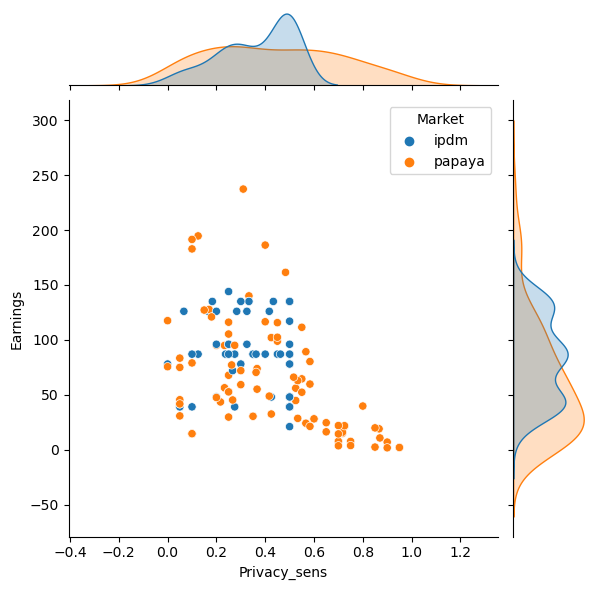

In [3]:
import seaborn as sns
df_earnings_privacy = df.groupby(["User_ID", "Market"]).agg(
    Earnings=("Earnings", "sum"), 
    Privacy_sens=("Privacy Sensitivity", "mean")
).reset_index()

#df_earnings_privacy
sns.jointplot(data = df_earnings_privacy, x = "Privacy_sens", y = "Earnings", hue = "Market");

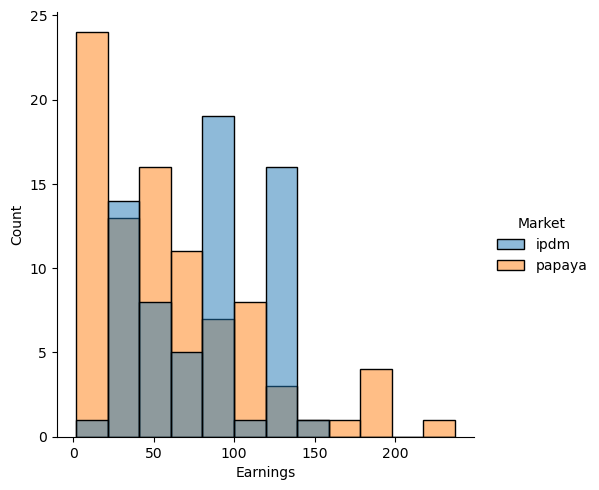

In [4]:
sns.displot(data = df_earnings_privacy, x = "Earnings", hue = "Market");

In [5]:
# Calculate Social Welfare for Each Market (IPDM vs Papaya)
# Social Welfare = Sum of Earnings + Remaining Platform Budgets

# Aggregate earnings by market
df["EarningsPC"] = df["Earnings"] * (1 - df["Privacy Cost"])
earningspc_by_market = df.groupby("Market")["EarningsPC"].sum()

# Calculate remaining platform budgets for each market
remaining_budget_ipdm = sum(platform.budget for platform in platforms_ipdm)
remaining_budget_papaya = sum(platform.budget for platform in platforms_papaya)

# Compute social welfare
social_welfare = {
    "IPDM": earningspc_by_market["ipdm"] + remaining_budget_ipdm,
    "Papaya Market": earningspc_by_market["papaya"] + remaining_budget_papaya
}

# Convert results to a DataFrame and display
social_welfare_df = pd.DataFrame.from_dict(social_welfare, orient="index", columns=["Social Welfare"])

social_welfare_df


,Social Welfare
IPDM,1260.000000
Papaya Market,1486.162432


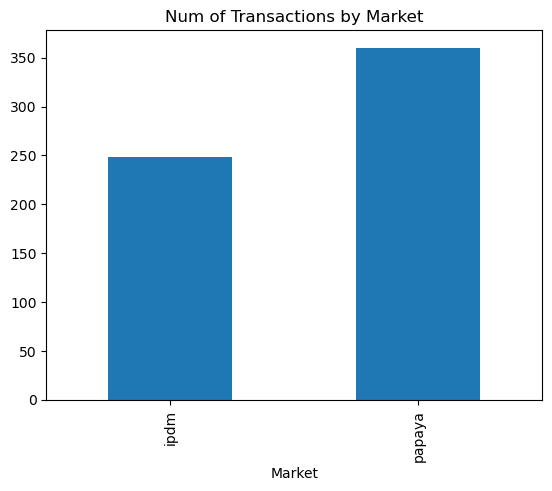

In [6]:
df.groupby("Market")["User_ID"].count().plot(kind="bar").set_title("Num of Transactions by Market");


In [7]:
print("Papaya privacy cost avg: ", df[df["Market"] == "papaya"]["Privacy Cost"].mean())
print("IPDM privacy cost avg: ", df[df["Market"] == "ipdm"]["Privacy Cost"].mean())

Papaya privacy cost avg:  0.6316666666666665
IPDM privacy cost avg:  0.7512096774193545


In [8]:
df.groupby("Market")["Earnings"].agg(["mean", "std", "median"])


,mean,std,median
Market,,,
ipdm,21.774194,5.756656,22.50
papaya,15.008069,10.893221,14.58


   Market  Total Social Welfare ($)
0    ipdm                5400.00000
1  papaya                5402.90478


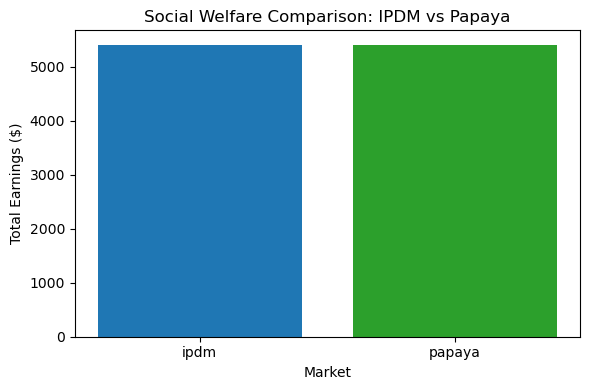

In [9]:
# Social Welfare = Sum of User Earnings in Each Market
social_welfare = df.groupby("Market")["Earnings"].sum().reset_index()
social_welfare.columns = ["Market", "Total Social Welfare ($)"]

# Display it
print(social_welfare)

# Optional: Bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(social_welfare["Market"], social_welfare["Total Social Welfare ($)"], color=["#1f77b4", "#2ca02c"])
plt.title("Social Welfare Comparison: IPDM vs Papaya")
plt.ylabel("Total Earnings ($)")
plt.xlabel("Market")
plt.tight_layout()
plt.show()


   Market    Earnings  Platform Utility  Total Social Welfare
0    ipdm  5400.00000          740.5000            6140.50000
1  papaya  5402.90478         5080.6587           10483.56348


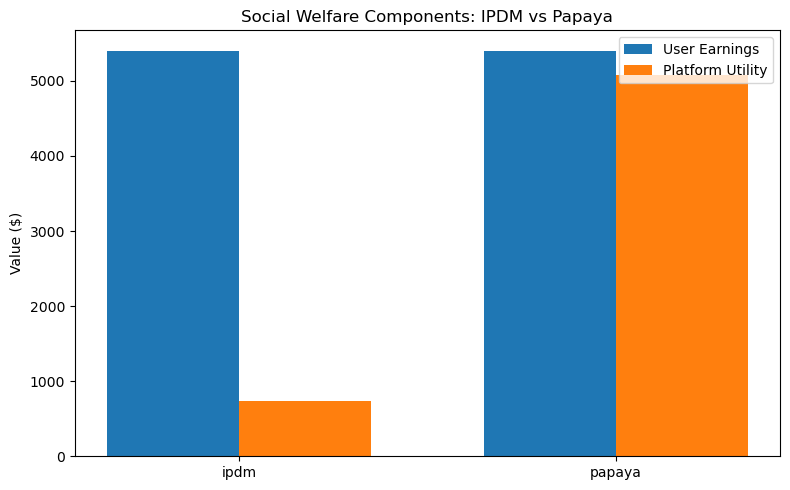

In [10]:
# Recalculate base value and profitability factor for each transaction
def compute_platform_utility(row, platforms_dict):
    platform_type = row["Platform"]
    purpose = row["Purpose"]
    market = row["Market"]

    # Get matching platform from dictionary
    key = (platform_type, market)
    platform = platforms_dict[key]

    base_value = platform.value_per_purpose[purpose]
    profitability = platform.profitability_factors.get(purpose, 1.0)

    value_derived = base_value * profitability
    price_paid = row["Earnings"] / (1 - platform.params["commission_rate"])

    return value_derived - price_paid

# Create a lookup for platform config
platforms_dict = {
    ("Advertisers", "ipdm"): platforms_ipdm[0],
    ("Retailers", "ipdm"): platforms_ipdm[1],
    ("Advertisers", "papaya"): platforms_papaya[0],
    ("Retailers", "papaya"): platforms_papaya[1],
}

# Add platform utility column to df
df["Platform Utility"] = df.apply(lambda row: compute_platform_utility(row, platforms_dict), axis=1)

# Compute total user earnings and platform utility
market_group = df.groupby("Market").agg({
    "Earnings": "sum",
    "Platform Utility": "sum"
}).reset_index()

# Add total social welfare column
market_group["Total Social Welfare"] = market_group["Earnings"] + market_group["Platform Utility"]

# Display results
print(market_group)

# Optional: Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
bar_width = 0.35
x = range(len(market_group))

plt.bar(x, market_group["Earnings"], width=bar_width, label="User Earnings")
plt.bar([p + bar_width for p in x], market_group["Platform Utility"], width=bar_width, label="Platform Utility")

plt.xticks([p + bar_width / 2 for p in x], market_group["Market"])
plt.ylabel("Value ($)")
plt.title("Social Welfare Components: IPDM vs Papaya")
plt.legend()
plt.tight_layout()
plt.show()
